In [1]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path('../python').resolve()
sys.path.append(str(utils_path))

import rasterio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from process_utils import (preprocess_data,
                           superpixel_segmentation,
                            tv_denoise, 
                            preprocess_for_merge)
from rio_utils import (reproject_arr_to_match_profile)
from edit_path_utils import (edit_paths)

In [2]:
# Opens a GeoTIFF and loads the backscatter values and profile
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
    return band, profile

In [3]:
def inc_filter(img):
    img_deg = np.rad2deg(img)
    mask = (img_deg < 20) | (img_deg > 60)
    img_deg[mask] = 999
    return img_deg

In [4]:
def denoise(data, weight):
    mask = np.isnan(data)
    data[mask] = 9999
    data_tv = tv_denoise(data, weight)
    data_tv[mask] = np.nan

    return data_tv

In [5]:
def weighted_inc_merge(img_0, img_1, inc_0, inc_1):
    
    valid_pixel_0 = ~np.isnan(img_0) & (inc_0 >= 20) & (inc_0 <= 60)
    valid_pixel_1 = ~np.isnan(img_1) & (inc_1 >= 20) & (inc_1 <= 60)
    invalid_pixel_0 = np.isnan(img_0) | (inc_0 < 20) | (inc_0 > 60)
    invalid_pixel_1 = np.isnan(img_1) | (inc_1 < 20) | (inc_1 > 60)

    w0 = inc_1 / (inc_0 + inc_1)
    w1 = inc_0 / (inc_0 + inc_1)
    img_merged = np.empty_like(img_0)
    img_merged[:] = np.nan

    # combine valid pixels
    img_merged[valid_pixel_0] = (w0 * img_0)[valid_pixel_0] + (w1 * img_1)[valid_pixel_0]
    img_merged[valid_pixel_1] = (w0 * img_0)[valid_pixel_1] + (w1 * img_1)[valid_pixel_1]

    # combine cases where one pixel is valid and the other is not
    img_merged[valid_pixel_0 & invalid_pixel_1] = img_0[valid_pixel_0 & invalid_pixel_1]
    img_merged[valid_pixel_1 & invalid_pixel_0] = img_1[valid_pixel_1 & invalid_pixel_0]

    return img_merged


In [6]:
data_dir = Path('/Volumes/BlackT7/bobcat_flight_paths')
tifs = sorted(list(data_dir.rglob('./*cropped*.tif')))

# adjust for wanted and unwanted tifs
include = [
            "181011"
          ]
exclude = [
            "hello"
          ]

tifs = edit_paths(include,exclude,tifs)
print(*tifs, sep="\n")

/Volumes/BlackT7/bobcat_flight_paths/SanAnd_08525_18076_003_181011_HVHV_rtc_cropped_25km.tif
/Volumes/BlackT7/bobcat_flight_paths/SanAnd_08525_18076_003_181011_HVHV_rtc_cropped_35km.tif
/Volumes/BlackT7/bobcat_flight_paths/SanAnd_26526_18076_002_181011_HVHV_rtc_cropped_25km.tif
/Volumes/BlackT7/bobcat_flight_paths/SanAnd_26526_18076_002_181011_HVHV_rtc_cropped_25km_shp_crop.tif
/Volumes/BlackT7/bobcat_flight_paths/test_bob/SanAnd_08525_18076_003_181011_HVHV_rtc_cropped_25km.tif
/Volumes/BlackT7/bobcat_flight_paths/test_bob/SanAnd_26526_18076_002_181011_HVHV_rtc_cropped_25km.tif


In [7]:
data_dir = Path('/Volumes/BlackT7/bobcat_flight_paths')
incs = sorted(list(data_dir.rglob('./*inc*.tif')))

# adjust for wanted and unwanted inc flight paths
include = [
            "181011"
          ]
exclude = [
            "hello"
          ]

incs = edit_paths(include,exclude,incs)
print(*incs, sep="\n")

/Volumes/BlackT7/bobcat_flight_paths/SanAnd_08525_18076_003_181011_L090_CX_01_inc_25km.tif
/Volumes/BlackT7/bobcat_flight_paths/SanAnd_08525_18076_003_181011_L090_CX_01_inc_35km.tif
/Volumes/BlackT7/bobcat_flight_paths/SanAnd_26526_18076_002_181011_L090_CX_01_inc_25km.tif
/Volumes/BlackT7/bobcat_flight_paths/SanAnd_26526_18076_002_181011_L090_CX_01_inc_25km_shp_crop.tif
/Volumes/BlackT7/bobcat_flight_paths/test_bob/SanAnd_08525_18076_003_181011_L090_CX_01_inc_25km.tif
/Volumes/BlackT7/bobcat_flight_paths/test_bob/SanAnd_26526_18076_002_181011_L090_CX_01_inc_25km.tif


In [87]:
bands, profiles = zip(*map(open_one, tifs))

bands = list(bands)
for i in range(len(bands)):
    bands[i] = preprocess_for_merge(bands[i]) # mask out the missing data after RTC. Scale the values to ensure consistency
    
pre_0 = bands[0]
post_0 = bands[1]
pre_1 = bands[2]
post_1 = bands[3]
profile_pre0 = profiles[0]
profile_post0 = profiles[1]
profile_pre1 = profiles[2]
profile_post1 = profiles[3]

In [88]:
inc_bands, inc_profiles = zip(*map(open_one, incs))

inc_bands = list(inc_bands)
for i in range(len(inc_bands)):
    inc_bands[i] = inc_filter(inc_bands[i]) # convert angle from radian to degree. Filter out the bad angles
    
pre_inc_0 = inc_bands[0]
post_inc_0 = inc_bands[1]
pre_inc_1 = inc_bands[2]
post_inc_1 = inc_bands[3]
profile_pre0_inc = inc_profiles[0]
profile_post0_inc = inc_profiles[1]
profile_pre1_inc = inc_profiles[2]
profile_post1_inc = inc_profiles[3]

In [89]:
resampling = 'nearest'

In [90]:
# Reprojecting all the images to match the profile of pre_0. 
# We would need to perform addition and division later so the shape has to match

pre_1, _ = reproject_arr_to_match_profile(pre_1, profile_pre1, profile_pre0, resampling=resampling)
pre_1 = pre_1[0]
post_0, _ = reproject_arr_to_match_profile(post_0, profile_post0, profile_pre0, resampling=resampling)
post_0 = post_0[0]
post_1, _ = reproject_arr_to_match_profile(post_1, profile_post1, profile_pre0, resampling=resampling)
post_1 = post_1[0]

pre_inc_0, _ = reproject_arr_to_match_profile(pre_inc_0, profile_pre0_inc, profile_pre0, resampling=resampling)
pre_inc_0 = pre_inc_0[0]
pre_inc_1, _ = reproject_arr_to_match_profile(pre_inc_1, profile_pre1_inc, profile_pre0, resampling=resampling)
pre_inc_1 = pre_inc_1[0]

post_inc_0, _ = reproject_arr_to_match_profile(post_inc_0, profile_post0_inc, profile_pre0, resampling=resampling)
post_inc_0 = post_inc_0[0]
post_inc_1, _ = reproject_arr_to_match_profile(post_inc_1, profile_post1_inc, profile_pre0, resampling=resampling)
post_inc_1 = post_inc_1[0]

In [91]:
# note we will get error message here as we are dividing everything, 
# but those pixels with invaid value encountered were not used for the merge.
# we only used the valid pixels for merging which should not cause error in division since 20 < inc < 60

hv_0 = weighted_inc_merge(pre_0, pre_1, pre_inc_0, pre_inc_1)
hv_1 = weighted_inc_merge(post_0, post_1, post_inc_0, post_inc_1)

In [92]:
output_path_0 = "/Volumes/BlackT7/bobcat_flight_paths/bobcat_26526_08525_hv_0.tif"
output_path_1 = "/Volumes/BlackT7/bobcat_flight_paths/bobcat_26526_08525_hv_1.tif"

In [93]:
with rasterio.open(output_path_0, "w", **profile_pre0) as dest:
    dest.write(hv_0, 1)
with rasterio.open(output_path_1, "w", **profile_pre0) as dest:
    dest.write(hv_1, 1)

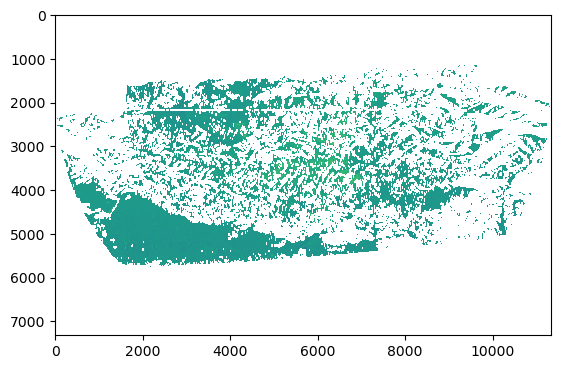

In [94]:
plt.imshow(np.log10(hv_0/hv_1))